In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import random
import torch

In [18]:
# Define paths and parameters
SEED = 25
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
tf.random.set_seed(SEED)

# Define paths and parameters
#train_dir = '/kaggle/input/mush-increase-res/kaggle/working/data'
train_dir = '/kaggle/input/mush-increase-res/kaggle/working/data'
img_width, img_height = 64, 64 
# AlexNet input size
batch_size = 8
num_classes = len(os.listdir(train_dir))  # Number of subfolders in train directory

In [19]:
print(f"Training on {num_classes} classes: {os.listdir(train_dir)}")

Training on 4 classes: ['Đùi gà Baby (cắt ngắn)', 'nấm mỡ', 'linh chi trắng', 'bào ngư xám + trắng']


In [21]:
import cv2

def to_grayscale_3channel(img):
    # img là ảnh RGB sau khi được load vào (dạng numpy array, shape (H, W, 3))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        # (H, W)
    gray_3channel = np.stack((gray,)*3, axis=-1)        # (H, W, 3)
    return gray_3channel

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% for validation
    #preprocessing_function=to_grayscale_3channel
    # brightness_range=(0.8, 1.2),
    # channel_shift_range=20,
    #horizontal_flip=True
    #fill_mode='nearest'
)

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 960 images belonging to 4 classes.


In [24]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 240 images belonging to 4 classes.


In [25]:
# #EfficientNetV2S -90 batch - 8 , 
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2L

# base_model = EfficientNetV2S(
#     input_shape=(64,64,3),
#     weights="imagenet",
#     input_tensor=None,
#     pooling=None,
#     include_top=False,
# )

base_model = EfficientNetV2L(
    input_shape=(64,64,3),
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    include_top=False,
)

# Tạo mô hình mới với lớp phân loại
model = models.Sequential([
    base_model,  # Thêm phần feature extractor
    layers.GlobalAveragePooling2D(),  # Pooling để chuyển từ 4D -> 2D
    layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Lớp phân loại
])

In [26]:
from tensorflow.keras.optimizers import AdamW

model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4),  # weight_decay giúp điều chỉnh regularization
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    'model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=70,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)



In [27]:
callbacks = [checkpoint, early_stopping]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)


Epoch 1/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5933 - loss: 1.0433
Epoch 1: val_accuracy improved from -inf to 0.69583, saving model to model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 312s 380ms/step - accuracy: 0.5943 - loss: 1.0412 - val_accuracy: 0.6958 - val_loss: 0.7593
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8455 - loss: 0.5154
Epoch 3: val_accuracy improved from 0.69583 to 0.81667, saving model to model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.8456 - loss: 0.5152 - val_accuracy: 0.8167 - val_loss: 0.5326
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8633 - loss: 0.4499
Epoch 5: val_accuracy improved from 0.81667 to 0.89167, saving model to model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 24s 198ms/step - accur

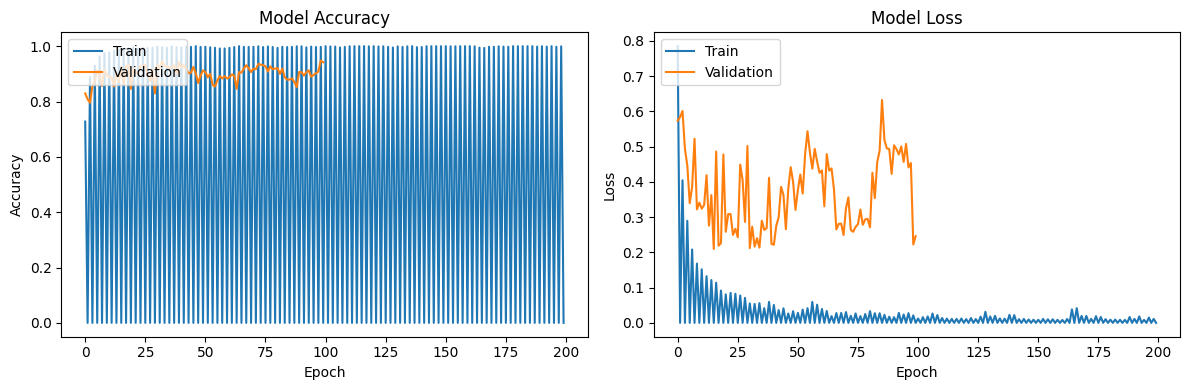

In [31]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('alexnet_training_history.png')
plt.show()

In [ ]:
#TEST

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.keras')


In [14]:
class_mapping = {
    0: 1,  # 'bào ngư xám + trắng' -> 'Nấm bào ngư' (1)
    1: 3,  # 'linh chi trắng' -> 'nấm linh chi trắng' (3)
    2: 0,  # 'nấm mỡ' -> 'nấm mỡ' (0)
    3: 2   # 'Đùi gà Baby (cắt ngắn)' -> 'Nấm đùi gà' (2)
}

In [15]:
# Tiền xử lý ảnh
def preprocess_image(img_path):  # Thay đổi target_size theo mô hình của bạn
    img = Image.open(img_path)
    #img = Image.open(img_path).convert("L").convert("RGB")
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
    img_array /= 255.0  # Chuẩn hóa pixel nếu cần
    return img_array

In [16]:
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.preprocessing import image
import pandas as pd

In [28]:
# Dự đoán từng ảnh
# Thư mục chứa ảnh test
test_folder = "/kaggle/input/private-test/kaggle/working/output_images"
image_files = sorted(os.listdir(test_folder))

results = []

for img_file in tqdm(image_files, desc="Processing images"):
    img_path = os.path.join(test_folder, img_file)

    img_array = preprocess_image(img_path)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]  # Lấy nhãn có xác suất cao nhất

    mapped_class = class_mapping[predicted_class]
    img_id = img_file.split('.')[0]  # Lấy phần số từ tên file
    results.append([img_id, mapped_class])

submission_df = pd.DataFrame(results, columns=['id', 'type'])
submission_df.to_csv("submission_V2L_42_inv_32.csv", index=False)

print("Dự đoán hoàn thành, file submission.csv đã được tạo.")


Processing images:   0%|          | 0/600 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


Processing images:   0%|          | 1/600 [00:14<2:28:42, 14.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   0%|          | 3/600 [00:15<39:06,  3.93s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:   1%|          | 5/600 [00:15<19:22,  1.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:   1%|          | 7/600 [00:15<11:29,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:   2%|▏         | 9/600 [00:15<07:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   2%|▏         | 11/600 [00:15<05:07,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   2%|▏         | 13/600 [00:15<03:40,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:   2%|▎         | 15/600 [00:16<02:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   3%|▎         | 17/600 [00:16<02:08,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   3%|▎         | 19/600 [00:16<01:45,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   4%|▎         | 21/600 [00:16<01:27,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:   4%|▍         | 23/600 [00:16<01:16,  7.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   4%|▍         | 25/600 [00:16<01:07,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   4%|▍         | 27/600 [00:17<01:01,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   5%|▍         | 29/600 [00:17<00:57,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   5%|▌         | 31/600 [00:17<00:54, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   6%|▌         | 33/600 [00:17<00:52, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing images:   6%|▌         | 35/600 [00:17<00:53, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:   6%|▌         | 37/600 [00:18<00:51, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   6%|▋         | 39/600 [00:18<00:50, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:   7%|▋         | 41/600 [00:18<00:56,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:   7%|▋         | 43/600 [00:18<00:53, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:   8%|▊         | 45/600 [00:18<00:51, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:   8%|▊         | 47/600 [00:18<00:49, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   8%|▊         | 49/600 [00:19<00:48, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:   8%|▊         | 51/600 [00:19<00:48, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:   9%|▉         | 53/600 [00:19<00:48, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:   9%|▉         | 55/600 [00:19<00:47, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  10%|▉         | 57/600 [00:19<00:46, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  10%|▉         | 59/600 [00:19<00:46, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  10%|█         | 61/600 [00:20<00:46, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  10%|█         | 63/600 [00:20<00:46, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  11%|█         | 65/600 [00:20<00:46, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  11%|█         | 67/600 [00:20<00:46, 11.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  12%|█▏        | 69/600 [00:20<00:46, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  12%|█▏        | 71/600 [00:21<00:45, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  12%|█▏        | 73/600 [00:21<00:45, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  12%|█▎        | 75/600 [00:21<00:45, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  13%|█▎        | 77/600 [00:21<00:45, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  13%|█▎        | 79/600 [00:21<00:45, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  14%|█▎        | 81/600 [00:21<00:44, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  14%|█▍        | 83/600 [00:22<00:44, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  14%|█▍        | 85/600 [00:22<00:43, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  14%|█▍        | 87/600 [00:22<00:43, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  15%|█▍        | 89/600 [00:22<00:43, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  15%|█▌        | 91/600 [00:22<00:43, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing images:  16%|█▌        | 93/600 [00:22<00:42, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  16%|█▌        | 95/600 [00:23<00:42, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  16%|█▌        | 97/600 [00:23<00:42, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  16%|█▋        | 99/600 [00:23<00:42, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  17%|█▋        | 101/600 [00:23<00:42, 11.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  17%|█▋        | 103/600 [00:23<00:42, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  18%|█▊        | 105/600 [00:23<00:41, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  18%|█▊        | 107/600 [00:24<00:41, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  18%|█▊        | 109/600 [00:24<00:41, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  18%|█▊        | 111/600 [00:24<00:41, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  19%|█▉        | 113/600 [00:24<00:41, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  19%|█▉        | 115/600 [00:24<00:41, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  20%|█▉        | 117/600 [00:24<00:42, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  20%|█▉        | 119/600 [00:25<00:42, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  20%|██        | 121/600 [00:25<00:41, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  20%|██        | 123/600 [00:25<00:42, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  21%|██        | 125/600 [00:25<00:42, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  21%|██        | 127/600 [00:25<00:41, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  22%|██▏       | 129/600 [00:26<00:41, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  22%|██▏       | 131/600 [00:26<00:41, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  22%|██▏       | 133/600 [00:26<00:41, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  22%|██▎       | 135/600 [00:26<00:41, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  23%|██▎       | 137/600 [00:26<00:41, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  23%|██▎       | 139/600 [00:26<00:41, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  24%|██▎       | 141/600 [00:27<00:40, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  24%|██▍       | 143/600 [00:27<00:40, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  24%|██▍       | 145/600 [00:27<00:40, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  24%|██▍       | 147/600 [00:27<00:40, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  25%|██▍       | 149/600 [00:27<00:40, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  25%|██▌       | 151/600 [00:28<00:41, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  26%|██▌       | 153/600 [00:28<00:41, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  26%|██▌       | 155/600 [00:28<00:40, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  26%|██▌       | 157/600 [00:28<00:40, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  26%|██▋       | 159/600 [00:28<00:40, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  27%|██▋       | 161/600 [00:28<00:40, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  27%|██▋       | 163/600 [00:29<00:39, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  28%|██▊       | 165/600 [00:29<00:39, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  28%|██▊       | 167/600 [00:29<00:38, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  28%|██▊       | 169/600 [00:29<00:38, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  28%|██▊       | 171/600 [00:29<00:38, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  29%|██▉       | 173/600 [00:29<00:38, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  29%|██▉       | 175/600 [00:30<00:38, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  30%|██▉       | 177/600 [00:30<00:37, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  30%|██▉       | 179/600 [00:30<00:37, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  30%|███       | 181/600 [00:30<00:37, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  30%|███       | 183/600 [00:30<00:37, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  31%|███       | 185/600 [00:31<00:37, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  31%|███       | 187/600 [00:31<00:37, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  32%|███▏      | 189/600 [00:31<00:37, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  32%|███▏      | 191/600 [00:31<00:37, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  32%|███▏      | 193/600 [00:31<00:37, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  32%|███▎      | 195/600 [00:31<00:36, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  33%|███▎      | 197/600 [00:32<00:36, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  33%|███▎      | 199/600 [00:32<00:36, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  34%|███▎      | 201/600 [00:32<00:36, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  34%|███▍      | 203/600 [00:32<00:35, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  34%|███▍      | 205/600 [00:32<00:35, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  34%|███▍      | 207/600 [00:33<00:35, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  35%|███▍      | 209/600 [00:33<00:35, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  35%|███▌      | 211/600 [00:33<00:34, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  36%|███▌      | 213/600 [00:33<00:34, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  36%|███▌      | 215/600 [00:33<00:34, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  36%|███▌      | 217/600 [00:33<00:33, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  36%|███▋      | 219/600 [00:34<00:33, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  37%|███▋      | 221/600 [00:34<00:34, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  37%|███▋      | 223/600 [00:34<00:34, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  38%|███▊      | 225/600 [00:34<00:33, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing images:  38%|███▊      | 227/600 [00:34<00:35, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing images:  38%|███▊      | 229/600 [00:35<00:34, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  38%|███▊      | 231/600 [00:35<00:35, 10.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  39%|███▉      | 233/600 [00:35<00:35, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  39%|███▉      | 235/600 [00:35<00:34, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  40%|███▉      | 237/600 [00:35<00:34, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  40%|███▉      | 239/600 [00:36<00:35, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  40%|████      | 241/600 [00:36<00:34, 10.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  40%|████      | 243/600 [00:36<00:33, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  41%|████      | 245/600 [00:36<00:33, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  41%|████      | 247/600 [00:36<00:33, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  42%|████▏     | 249/600 [00:36<00:32, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  42%|████▏     | 251/600 [00:37<00:31, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  42%|████▏     | 253/600 [00:37<00:31, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  42%|████▎     | 255/600 [00:37<00:31, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing images:  43%|████▎     | 257/600 [00:37<00:31, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing images:  43%|████▎     | 259/600 [00:37<00:32, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  44%|████▎     | 261/600 [00:38<00:32, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  44%|████▍     | 263/600 [00:38<00:31, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  44%|████▍     | 265/600 [00:38<00:30, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  44%|████▍     | 267/600 [00:38<00:30, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  45%|████▍     | 269/600 [00:38<00:29, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  45%|████▌     | 271/600 [00:38<00:28, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  46%|████▌     | 273/600 [00:39<00:28, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  46%|████▌     | 275/600 [00:39<00:27, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  46%|████▌     | 277/600 [00:39<00:27, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  46%|████▋     | 279/600 [00:39<00:27, 11.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  47%|████▋     | 281/600 [00:39<00:27, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  47%|████▋     | 283/600 [00:39<00:27, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  48%|████▊     | 285/600 [00:40<00:27, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  48%|████▊     | 287/600 [00:40<00:27, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  48%|████▊     | 289/600 [00:40<00:27, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  48%|████▊     | 291/600 [00:40<00:27, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  49%|████▉     | 293/600 [00:40<00:27, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  49%|████▉     | 295/600 [00:41<00:26, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  50%|████▉     | 297/600 [00:41<00:26, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  50%|████▉     | 299/600 [00:41<00:26, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  50%|█████     | 301/600 [00:41<00:26, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  50%|█████     | 303/600 [00:41<00:26, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  51%|█████     | 305/600 [00:41<00:25, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  51%|█████     | 307/600 [00:42<00:25, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  52%|█████▏    | 309/600 [00:42<00:25, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  52%|█████▏    | 311/600 [00:42<00:25, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  52%|█████▏    | 313/600 [00:42<00:25, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  52%|█████▎    | 315/600 [00:42<00:25, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing images:  53%|█████▎    | 317/600 [00:42<00:25, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  53%|█████▎    | 319/600 [00:43<00:25, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  54%|█████▎    | 321/600 [00:43<00:25, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  54%|█████▍    | 323/600 [00:43<00:25, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  54%|█████▍    | 325/600 [00:43<00:24, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  55%|█████▍    | 327/600 [00:43<00:24, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  55%|█████▍    | 329/600 [00:44<00:24, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  55%|█████▌    | 331/600 [00:44<00:23, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  56%|█████▌    | 333/600 [00:44<00:23, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  56%|█████▌    | 335/600 [00:44<00:23, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  56%|█████▌    | 337/600 [00:44<00:23, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  56%|█████▋    | 339/600 [00:44<00:23, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  57%|█████▋    | 341/600 [00:45<00:22, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  57%|█████▋    | 343/600 [00:45<00:22, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  57%|█████▊    | 345/600 [00:45<00:22, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  58%|█████▊    | 347/600 [00:45<00:22, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  58%|█████▊    | 349/600 [00:45<00:21, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  58%|█████▊    | 351/600 [00:45<00:21, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  59%|█████▉    | 353/600 [00:46<00:21, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  59%|█████▉    | 355/600 [00:46<00:21, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  60%|█████▉    | 357/600 [00:46<00:21, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  60%|█████▉    | 359/600 [00:46<00:21, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  60%|██████    | 361/600 [00:46<00:21, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  60%|██████    | 363/600 [00:47<00:21, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  61%|██████    | 365/600 [00:47<00:20, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  61%|██████    | 367/600 [00:47<00:20, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  62%|██████▏   | 369/600 [00:47<00:20, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  62%|██████▏   | 371/600 [00:47<00:20, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  62%|██████▏   | 373/600 [00:47<00:20, 10.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  62%|██████▎   | 375/600 [00:48<00:20, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  63%|██████▎   | 377/600 [00:48<00:20, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  63%|██████▎   | 379/600 [00:48<00:19, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  64%|██████▎   | 381/600 [00:48<00:19, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  64%|██████▍   | 383/600 [00:48<00:19, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  64%|██████▍   | 385/600 [00:49<00:18, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  64%|██████▍   | 387/600 [00:49<00:18, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  65%|██████▍   | 389/600 [00:49<00:18, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  65%|██████▌   | 391/600 [00:49<00:18, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  66%|██████▌   | 393/600 [00:49<00:18, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  66%|██████▌   | 395/600 [00:49<00:18, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  66%|██████▌   | 397/600 [00:50<00:18, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  66%|██████▋   | 399/600 [00:50<00:18, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  67%|██████▋   | 401/600 [00:50<00:18, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  67%|██████▋   | 403/600 [00:50<00:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  68%|██████▊   | 405/600 [00:50<00:17, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  68%|██████▊   | 407/600 [00:51<00:17, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  68%|██████▊   | 409/600 [00:51<00:17, 11.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  68%|██████▊   | 411/600 [00:51<00:17, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  69%|██████▉   | 413/600 [00:51<00:16, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  69%|██████▉   | 415/600 [00:51<00:16, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  70%|██████▉   | 417/600 [00:51<00:16, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  70%|██████▉   | 419/600 [00:52<00:16, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  70%|███████   | 421/600 [00:52<00:15, 11.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  70%|███████   | 423/600 [00:52<00:15, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  71%|███████   | 425/600 [00:52<00:15, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  71%|███████   | 427/600 [00:52<00:15, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  72%|███████▏  | 429/600 [00:52<00:15, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  72%|███████▏  | 431/600 [00:53<00:15, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  72%|███████▏  | 433/600 [00:53<00:14, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  72%|███████▎  | 435/600 [00:53<00:14, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  73%|███████▎  | 437/600 [00:53<00:14, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  73%|███████▎  | 439/600 [00:53<00:14, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  74%|███████▎  | 441/600 [00:54<00:14, 11.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  74%|███████▍  | 443/600 [00:54<00:14, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  74%|███████▍  | 445/600 [00:54<00:13, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  74%|███████▍  | 447/600 [00:54<00:13, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  75%|███████▍  | 449/600 [00:54<00:13, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  75%|███████▌  | 451/600 [00:54<00:13, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  76%|███████▌  | 453/600 [00:55<00:13, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  76%|███████▌  | 455/600 [00:55<00:12, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  76%|███████▌  | 457/600 [00:55<00:12, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  76%|███████▋  | 459/600 [00:55<00:12, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  77%|███████▋  | 461/600 [00:55<00:12, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  77%|███████▋  | 463/600 [00:56<00:12, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  78%|███████▊  | 465/600 [00:56<00:12, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  78%|███████▊  | 467/600 [00:56<00:11, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  78%|███████▊  | 469/600 [00:56<00:11, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  78%|███████▊  | 471/600 [00:56<00:11, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  79%|███████▉  | 473/600 [00:56<00:12, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  79%|███████▉  | 475/600 [00:57<00:11, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing images:  80%|███████▉  | 477/600 [00:57<00:11, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  80%|███████▉  | 479/600 [00:57<00:11, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  80%|████████  | 481/600 [00:57<00:11, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing images:  80%|████████  | 483/600 [00:57<00:11, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  81%|████████  | 485/600 [00:58<00:10, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  81%|████████  | 487/600 [00:58<00:10, 10.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  82%|████████▏ | 489/600 [00:58<00:10, 10.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  82%|████████▏ | 491/600 [00:58<00:09, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  82%|████████▏ | 493/600 [00:58<00:09, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  82%|████████▎ | 495/600 [00:58<00:09, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  83%|████████▎ | 497/600 [00:59<00:09, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  83%|████████▎ | 499/600 [00:59<00:08, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  84%|████████▎ | 501/600 [00:59<00:08, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing images:  84%|████████▍ | 503/600 [00:59<00:08, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing images:  84%|████████▍ | 505/600 [00:59<00:08, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  84%|████████▍ | 507/600 [01:00<00:08, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  85%|████████▍ | 509/600 [01:00<00:07, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  85%|████████▌ | 511/600 [01:00<00:07, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  86%|████████▌ | 513/600 [01:00<00:07, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  86%|████████▌ | 515/600 [01:00<00:07, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  86%|████████▌ | 517/600 [01:00<00:07, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  86%|████████▋ | 519/600 [01:01<00:07, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  87%|████████▋ | 521/600 [01:01<00:06, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  87%|████████▋ | 523/600 [01:01<00:06, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  88%|████████▊ | 525/600 [01:01<00:06, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  88%|████████▊ | 527/600 [01:01<00:06, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  88%|████████▊ | 529/600 [01:01<00:06, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  88%|████████▊ | 531/600 [01:02<00:05, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  89%|████████▉ | 533/600 [01:02<00:05, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  89%|████████▉ | 535/600 [01:02<00:05, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  90%|████████▉ | 537/600 [01:02<00:05, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  90%|████████▉ | 539/600 [01:02<00:05, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  90%|█████████ | 541/600 [01:02<00:05, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  90%|█████████ | 543/600 [01:03<00:05, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  91%|█████████ | 545/600 [01:03<00:04, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  91%|█████████ | 547/600 [01:03<00:04, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  92%|█████████▏| 549/600 [01:03<00:04, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  92%|█████████▏| 551/600 [01:03<00:04, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images:  92%|█████████▏| 553/600 [01:04<00:04, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  92%|█████████▎| 555/600 [01:04<00:03, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  93%|█████████▎| 557/600 [01:04<00:03, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  93%|█████████▎| 559/600 [01:04<00:03, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  94%|█████████▎| 561/600 [01:04<00:03, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  94%|█████████▍| 563/600 [01:04<00:03, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  94%|█████████▍| 565/600 [01:05<00:03, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  94%|█████████▍| 567/600 [01:05<00:02, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  95%|█████████▍| 569/600 [01:05<00:02, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  95%|█████████▌| 571/600 [01:05<00:02, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  96%|█████████▌| 573/600 [01:05<00:02, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  96%|█████████▌| 575/600 [01:05<00:02, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing images:  96%|█████████▌| 577/600 [01:06<00:01, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images:  96%|█████████▋| 579/600 [01:06<00:01, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing images:  97%|█████████▋| 581/600 [01:06<00:01, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing images:  97%|█████████▋| 583/600 [01:06<00:01, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing images:  98%|█████████▊| 585/600 [01:06<00:01, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing images:  98%|█████████▊| 587/600 [01:07<00:01, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing images:  98%|█████████▊| 589/600 [01:07<00:01, 10.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images:  98%|█████████▊| 591/600 [01:07<00:00, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing images:  99%|█████████▉| 593/600 [01:07<00:00, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing images:  99%|█████████▉| 595/600 [01:07<00:00, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing images: 100%|█████████▉| 597/600 [01:08<00:00, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing images: 100%|█████████▉| 599/600 [01:08<00:00, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing images: 100%|██████████| 600/600 [01:08<00:00,  8.79it/s]

Dự đoán hoàn thành, file submission.csv đã được tạo.


In [ ]:
submission_df = pd.DataFrame(results, columns=['id', 'type'])
submission_df.to_csv("submission_28.csv", index=False)

print("Dự đoán hoàn thành, file submission.csv đã được tạo.")
